In [97]:
from pathlib import Path

import polars as pl
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt


In [82]:
pl.__version__

'1.17.1'

In [83]:
project = Path().home().cwd().parent
data = project / "data"
fitbitdata = data / "Takeout" / "Fitbit"

In [84]:
data_collection: dict[str, list[Path]] = {}

for subdir in fitbitdata.glob("*"):
    for file in subdir.glob("*.csv"):
        topic = subdir.parts[-1]
        if topic in data_collection.keys():
            data_collection[topic].append(file)
        else:
            data_collection[topic] = [file]

In [85]:
step_files = filter(
    lambda p: "steps" in p.parts[-1], data_collection["Physical Activity_GoogleData"]
)


query = pl.scan_csv(list(step_files), schema_overrides={"timestamp": pl.Datetime})

In [86]:
query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("steps").sum()
)

day_name_map = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday",
}


query = query.with_columns(
    weekday=pl.col("timestamp").dt.weekday().replace_strict(day_name_map, default="")
)


(steps_df := query.collect())

timestamp,steps,weekday
datetime[μs],i64,str
2024-11-22 00:00:00,13,"""Friday"""
2024-11-23 00:00:00,10323,"""Saturday"""
2024-11-24 00:00:00,10188,"""Sunday"""
2024-11-25 00:00:00,7635,"""Monday"""
2024-11-26 00:00:00,11226,"""Tuesday"""
…,…,…
2024-12-06 00:00:00,9979,"""Friday"""
2024-12-07 00:00:00,11329,"""Saturday"""
2024-12-08 00:00:00,13713,"""Sunday"""


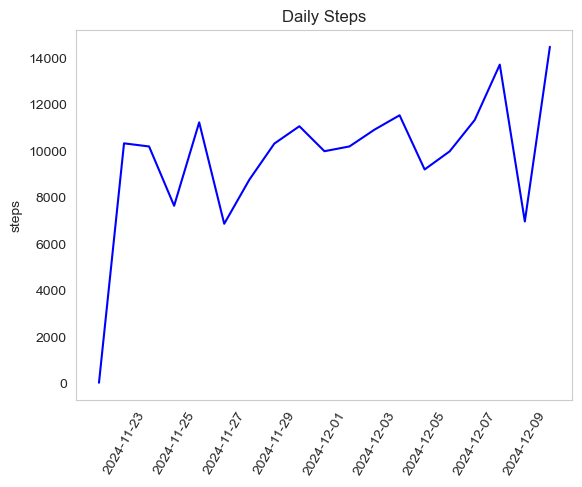

In [104]:
sns.lineplot(
    data=steps_df,
    x="timestamp",
    y="steps",
    markers="*",
    color="blue"
)

sns.set_style("whitegrid")
plt.xticks(rotation=60)
plt.title(label="Daily Steps")
plt.xlabel("")
plt.show()

In [95]:
hrv_files = filter(
    lambda p: "Heart Rate Variability Details" in p.parts[-1],
    data_collection["Heart Rate Variability"],
)


query = pl.scan_csv(list(hrv_files), schema_overrides={"timestamp": pl.Datetime}).sort(
    by="timestamp"
)

query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("rmssd").mean().alias("mean_rmsd"),
    pl.col("rmssd").quantile(0.25).name.suffix("_Q25%"),
    pl.col("rmssd").quantile(0.5).name.suffix("_Q50%"),
    pl.col("rmssd").quantile(0.75).name.suffix("_Q75%"),
    pl.col("rmssd").quantile(1).name.suffix("_Q100%"),
)


(hrv_df := query.collect())

timestamp,mean_rmsd,rmssd_Q25%,rmssd_Q50%,rmssd_Q75%,rmssd_Q100%
datetime[μs],f64,f64,f64,f64,f64
2024-11-22 00:00:00,69.81666,55.437,67.633,87.076,133.102
2024-11-23 00:00:00,65.9518,63.95,65.311,66.855,72.423
2024-11-24 00:00:00,76.533101,64.429,71.915,87.927,143.02
2024-11-25 00:00:00,86.195319,72.303,86.847,101.841,122.198
2024-11-26 00:00:00,63.226383,52.413,64.396,76.53,96.715
…,…,…,…,…,…
2024-12-05 00:00:00,77.366391,64.198,79.46,94.146,129.337
2024-12-06 00:00:00,47.141798,41.741,49.856,53.624,83.32
2024-12-07 00:00:00,65.004343,44.713,66.168,81.677,131.493


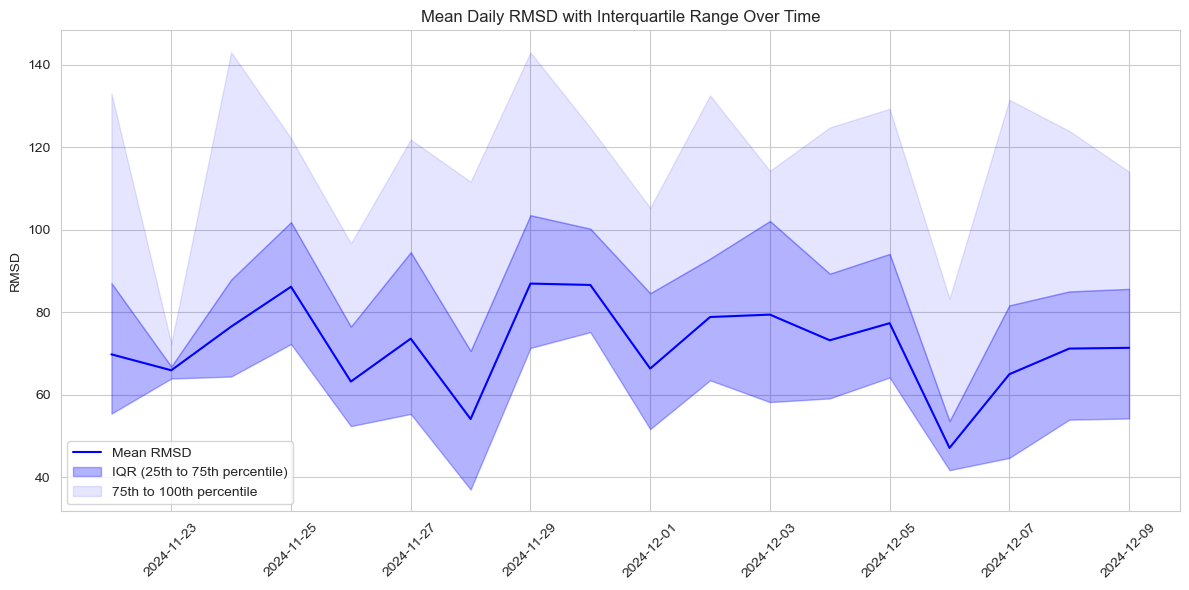

In [105]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

sns.lineplot(data=hrv_df, x='timestamp', y='mean_rmsd', label='Mean RMSD', color='blue')

plt.fill_between(
    hrv_df['timestamp'],
    hrv_df['rmssd_Q25%'],
    hrv_df['rmssd_Q75%'],
    color='blue',
    alpha=0.3,
    label='IQR (25th to 75th percentile)'
)

if 'rmssd_Q100%' in hrv_df.columns:
    plt.fill_between(
        hrv_df['timestamp'],
        hrv_df['rmssd_Q75%'],
        hrv_df['rmssd_Q100%'],
        color='blue',
        alpha=0.1,
        label='75th to 100th percentile'
    )

plt.xlabel('')
plt.ylabel('RMSD')
plt.title('Mean Daily RMSD with Interquartile Range Over Time')

plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


In [106]:
sp02_files = filter(
    lambda p: "Minute Sp02" in p.parts[-1],
    data_collection["Oxygen Saturation (SpO2)"],
)


query = pl.scan_csv(list(hrv_files), schema_overrides={"timestamp": pl.Datetime}).sort(
    by="timestamp"
)

# query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
#     pl.col("rmssd").mean().alias("mean_rmsd"),
#     pl.col("rmssd").quantile(0.25).name.suffix("_Q25%"),
#     pl.col("rmssd").quantile(0.5).name.suffix("_Q50%"),
#     pl.col("rmssd").quantile(0.75).name.suffix("_Q75%"),
#     pl.col("rmssd").quantile(1).name.suffix("_Q100%"),
# )


(sp02_df := query.collect())

ComputeError: expected at least 1 source

This error occurred with the following context stack:
	[1] 'csv scan'
	[2] 'sort'


In [91]:
(steps_df
 .select(pl.col(["timestamp", "steps"]))
 .join(
     hrv_df.select(pl.col(["timestamp", "mean_rmsd"])),
     on="timestamp")
 )

timestamp,steps,mean_rmsd
datetime[μs],i64,f64
2024-11-22 00:00:00,13,69.81666
2024-11-23 00:00:00,10323,65.9518
2024-11-24 00:00:00,10188,76.533101
2024-11-25 00:00:00,7635,86.195319
2024-11-26 00:00:00,11226,63.226383
…,…,…
2024-12-05 00:00:00,9198,77.366391
2024-12-06 00:00:00,9979,47.141798
2024-12-07 00:00:00,11329,65.004343
